In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [46]:
df = pd.read_csv("telcom_data.csv")

In [47]:
df.columns = [col.strip().replace(' ', '_').replace('.', '') for col in df.columns]

In [48]:
df.shape

(150001, 55)

In [49]:
df.columns

Index(['Bearer_Id', 'Start', 'Start_ms', 'End', 'End_ms', 'Dur_(ms)', 'IMSI',
       'MSISDN/Number', 'IMEI', 'Last_Location_Name', 'Avg_RTT_DL_(ms)',
       'Avg_RTT_UL_(ms)', 'Avg_Bearer_TP_DL_(kbps)', 'Avg_Bearer_TP_UL_(kbps)',
       'TCP_DL_Retrans_Vol_(Bytes)', 'TCP_UL_Retrans_Vol_(Bytes)',
       'DL_TP_<_50_Kbps_(%)', '50_Kbps_<_DL_TP_<_250_Kbps_(%)',
       '250_Kbps_<_DL_TP_<_1_Mbps_(%)', 'DL_TP_>_1_Mbps_(%)',
       'UL_TP_<_10_Kbps_(%)', '10_Kbps_<_UL_TP_<_50_Kbps_(%)',
       '50_Kbps_<_UL_TP_<_300_Kbps_(%)', 'UL_TP_>_300_Kbps_(%)',
       'HTTP_DL_(Bytes)', 'HTTP_UL_(Bytes)', 'Activity_Duration_DL_(ms)',
       'Activity_Duration_UL_(ms)', 'Dur_(ms)1', 'Handset_Manufacturer',
       'Handset_Type', 'Nb_of_sec_with_125000B_<_Vol_DL',
       'Nb_of_sec_with_1250B_<_Vol_UL_<_6250B',
       'Nb_of_sec_with_31250B_<_Vol_DL_<_125000B',
       'Nb_of_sec_with_37500B_<_Vol_UL',
       'Nb_of_sec_with_6250B_<_Vol_DL_<_31250B',
       'Nb_of_sec_with_6250B_<_Vol_UL_<_37500B',
     

In [50]:
df.columns = df.columns.str.strip()

# ----------- Task 3.1 - Aggregate per customer (clean missing & outliers) -----------

In [51]:
# Columns for experience analysis
experience_cols = [
    'TCP_DL_Retrans_Vol_(Bytes)', 'TCP_UL_Retrans_Vol_(Bytes)',
    'Avg_RTT_DL_(ms)', 'Avg_RTT_UL_(ms)',
    'Avg_Bearer_TP_DL_(kbps)', 'Avg_Bearer_TP_UL_(kbps)',
    'Handset_Type', 'MSISDN/Number'
]

df_exp = df[experience_cols].copy()

# Replace missing values
for col in df_exp.select_dtypes(include=np.number).columns:
    df_exp[col].fillna(df_exp[col].mean(), inplace=True)

df_exp['Handset_Type'].fillna(df_exp['Handset_Type'].mode()[0], inplace=True)

C:\Users\Dimple\AppData\Local\Temp\ipykernel_19528\1076295172.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_exp[col].fillna(df_exp[col].mean(), inplace=True)
C:\Users\Dimple\AppData\Local\Temp\ipykernel_19528\1076295172.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


In [52]:
# Outlier treatment using IQR
def remove_outliers_iqr(col):
    Q1 = df_exp[col].quantile(0.25)
    Q3 = df_exp[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df_exp[col] = np.where((df_exp[col] < lower) | (df_exp[col] > upper), df_exp[col].mean(), df_exp[col])

for col in df_exp.select_dtypes(include=np.number).columns:
    remove_outliers_iqr(col)
print(remove_outliers_iqr)

<function remove_outliers_iqr at 0x0000013C30471C60>


In [53]:
# Compute average per customer
agg_df = df_exp.groupby('MSISDN/Number').agg({
    'TCP_DL_Retrans_Vol_(Bytes)': 'mean',
    'TCP_UL_Retrans_Vol_(Bytes)': 'mean',
    'Avg_RTT_DL_(ms)': 'mean',
    'Avg_RTT_UL_(ms)': 'mean',
    'Avg_Bearer_TP_DL_(kbps)': 'mean',
    'Avg_Bearer_TP_UL_(kbps)': 'mean',
    'Handset_Type': lambda x: x.mode()[0]  # most common handset type
}).reset_index()

In [54]:
# Rename columns for clarity
agg_df.rename(columns={
    'TCP_DL_Retrans_Vol_(Bytes)': 'Avg_TCP_DL_Retrans',
    'TCP_UL_Retrans_Vol_(Bytes)': 'Avg_TCP_UL_Retrans',
    'Avg_RTT_DL_(ms)': 'Avg_RTT_DL',
    'Avg_RTT_UL_(ms)': 'Avg_RTT_UL',
    'Avg_Bearer_TP_DL_(kbps)': 'Avg_DL_Throughput',
    'Avg_Bearer_TP_UL_(kbps)': 'Avg_UL_Throughput'
}, inplace=True)

# ----------- Task 3.2 - Top, Bottom, and Most Frequent values -----------

In [55]:
def print_top_bottom_frequent(df, col, name):
    print(f"\nTop 10 {name} values:")
    print(df[col].nlargest(10))
    
    print(f"\nBottom 10 {name} values:")
    print(df[col].nsmallest(10))

    print(f"\nMost Frequent {name} values:")
    print(df[col].value_counts().head(10))

print_top_bottom_frequent(df_exp, 'TCP_DL_Retrans_Vol_(Bytes)', "TCP DL Retransmission")
print_top_bottom_frequent(df_exp, 'Avg_RTT_DL_(ms)', "RTT DL")
print_top_bottom_frequent(df_exp, 'Avg_Bearer_TP_DL_(kbps)', "DL Throughput")


Top 10 TCP DL Retransmission values:
6395      50021024.0
138714    49991791.0
66750     49986834.0
136230    49986038.0
76014     49969605.0
77812     49921268.0
143262    49833677.0
116514    49779123.0
9704      49777538.0
139859    49663906.0
Name: TCP_DL_Retrans_Vol_(Bytes), dtype: float64

Bottom 10 TCP DL Retransmission values:
59708     2.0
125088    2.0
2818      4.0
39582     4.0
52480     4.0
60366     4.0
60417     4.0
75082     4.0
100305    4.0
143429    4.0
Name: TCP_DL_Retrans_Vol_(Bytes), dtype: float64

Most Frequent TCP DL Retransmission values:
TCP_DL_Retrans_Vol_(Bytes)
2.080991e+07    88146
2.080991e+07     2525
1.330000e+03      433
2.660000e+03      219
3.800000e+01      200
9.200000e+01      192
1.318000e+03      156
5.430000e+02      133
3.990000e+03      114
7.600000e+01      108
Name: count, dtype: int64

Top 10 RTT DL values:
472      221.0
3092     221.0
5387     221.0
5799     221.0
8441     221.0
9369     221.0
10438    221.0
14101    221.0
17454    221

# ----------- Task 3.3 - Distribution per Handset Type -----------

C:\Users\Dimple\AppData\Local\Temp\ipykernel_19528\1833795381.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


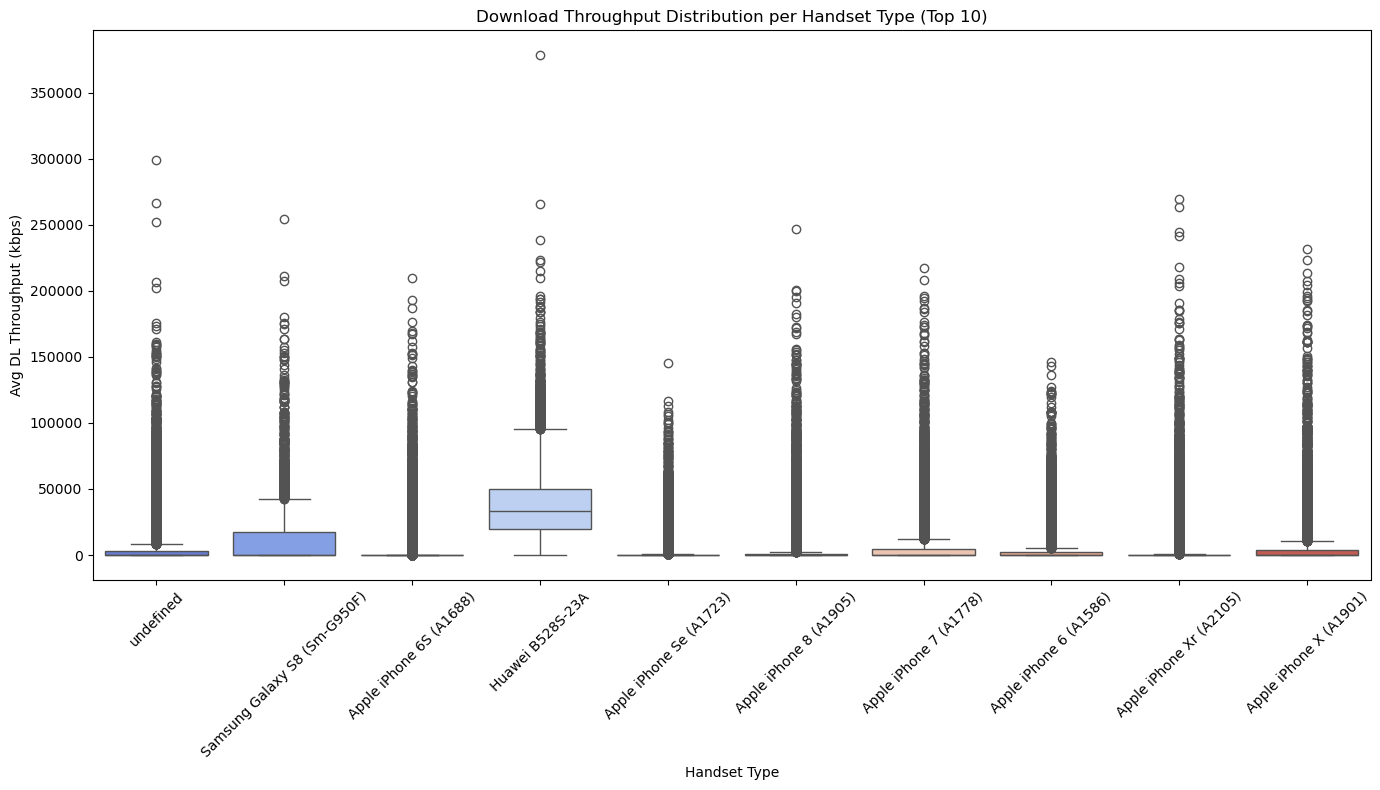

In [56]:
# Merge original df with aggregated throughput to preserve full distribution
merged_df = df[['Handset_Type', 'Avg_Bearer_TP_DL_(kbps)']].copy()
merged_df = merged_df.dropna()

# Strip column names in case of hidden spaces
merged_df.columns = merged_df.columns.str.strip()

# Plot: Boxplot of Download Throughput per Handset Type
plt.figure(figsize=(14, 8))
top_handsets = merged_df['Handset_Type'].value_counts().head(10).index
sns.boxplot(
    data=merged_df[merged_df['Handset_Type'].isin(top_handsets)],
    x='Handset_Type',
    y='Avg_Bearer_TP_DL_(kbps)',
    palette='coolwarm'
)
plt.title("Download Throughput Distribution per Handset Type (Top 10)")
plt.ylabel("Avg DL Throughput (kbps)")
plt.xlabel("Handset Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\Dimple\AppData\Local\Temp\ipykernel_19528\3140543532.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


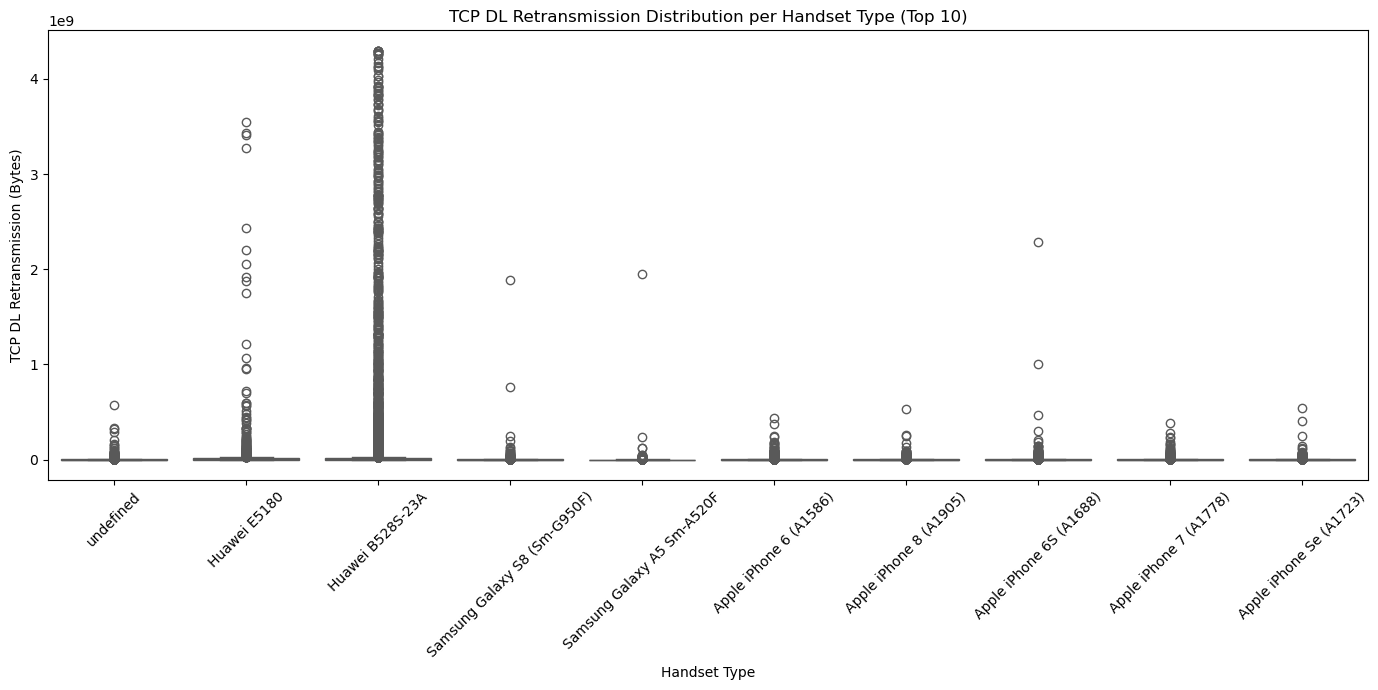

In [57]:
tcp_df = df[['Handset_Type', 'TCP_DL_Retrans_Vol_(Bytes)']].dropna()

# Optional: limit to most common handset types for cleaner plot
top_handsets = tcp_df['Handset_Type'].value_counts().head(10).index
tcp_df = tcp_df[tcp_df['Handset_Type'].isin(top_handsets)]

# Plot boxplot
plt.figure(figsize=(14, 7))
sns.boxplot(
    data=tcp_df,
    x='Handset_Type',
    y='TCP_DL_Retrans_Vol_(Bytes)',
    palette='Set2'
)
plt.title("TCP DL Retransmission Distribution per Handset Type (Top 10)")
plt.ylabel("TCP DL Retransmission (Bytes)")
plt.xlabel("Handset Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\Dimple\AppData\Local\Temp\ipykernel_19528\2728912813.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


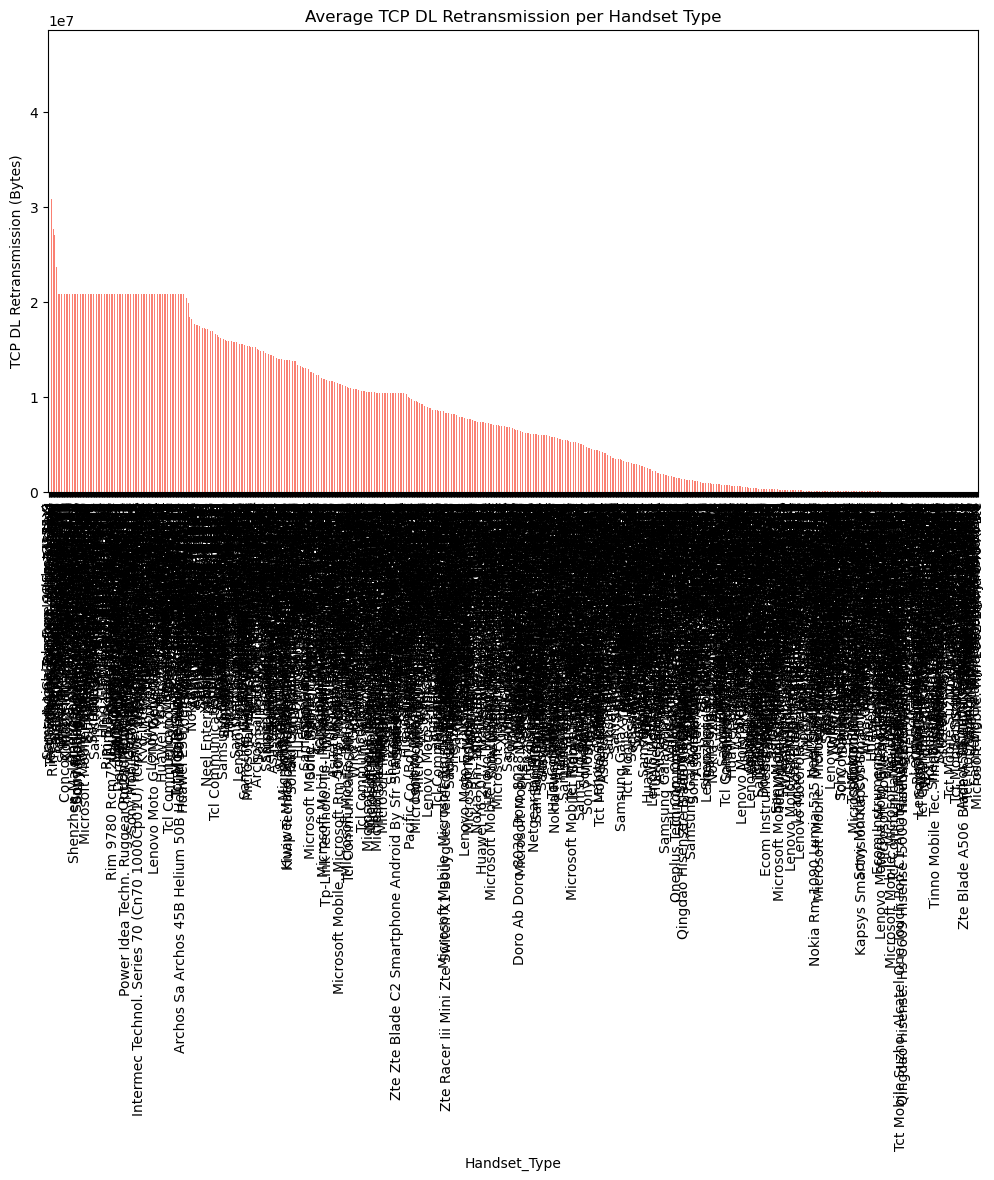

In [61]:
# TCP retransmission per handset type
tcp_retrans_by_handset = agg_df.groupby('Handset_Type')['Avg_TCP_DL_Retrans'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,6))
tcp_retrans_by_handset.plot(kind='bar', color='salmon')
plt.title("Average TCP DL Retransmission per Handset Type")
plt.ylabel("TCP DL Retransmission (Bytes)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# ----------- Task 3.4 - KMeans Clustering (k=3) -----------

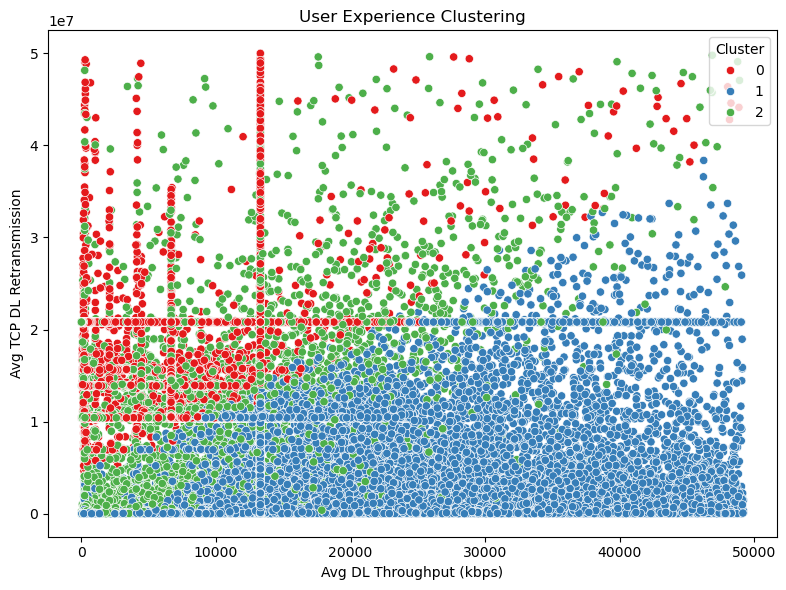

In [62]:
# Features for clustering
cluster_df = agg_df[['Avg_TCP_DL_Retrans', 'Avg_RTT_DL', 'Avg_DL_Throughput']].copy()

# Scale features
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_df)

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
agg_df['Cluster'] = kmeans.fit_predict(cluster_scaled)

# Visualize clusters
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=agg_df['Avg_DL_Throughput'],
    y=agg_df['Avg_TCP_DL_Retrans'],
    hue=agg_df['Cluster'],
    palette='Set1'
)
plt.title("User Experience Clustering")
plt.xlabel("Avg DL Throughput (kbps)")
plt.ylabel("Avg TCP DL Retransmission")
plt.tight_layout()
plt.show()

In [63]:
# Cluster descriptions
for i in range(3):
    cluster_data = agg_df[agg_df['Cluster'] == i]
    print(f"\nCluster {i} Summary:")
    print(f"Avg DL Throughput: {cluster_data['Avg_DL_Throughput'].mean():.2f}")
    print(f"Avg TCP Retransmission: {cluster_data['Avg_TCP_DL_Retrans'].mean():.2f}")
    print(f"Avg RTT DL: {cluster_data['Avg_RTT_DL'].mean():.2f}")
    print(f"Users in cluster: {len(cluster_data)}")

# Interpretation
print("\nCluster Interpretations:")
print("Cluster 0: Likely high throughput, low retransmission - Good experience.")
print("Cluster 1: Moderate throughput and retransmission - Average experience.")
print("Cluster 2: Low throughput, high retransmission - Poor experience.")


Cluster 0 Summary:
Avg DL Throughput: 1443.47
Avg TCP Retransmission: 19739609.46
Avg RTT DL: 38.70
Users in cluster: 37354

Cluster 1 Summary:
Avg DL Throughput: 19457.71
Avg TCP Retransmission: 3670859.19
Avg RTT DL: 62.26
Users in cluster: 26145

Cluster 2 Summary:
Avg DL Throughput: 2582.35
Avg TCP Retransmission: 16797220.56
Avg RTT DL: 112.84
Users in cluster: 26538

Cluster Interpretations:
Cluster 0: Likely high throughput, low retransmission - Good experience.
Cluster 1: Moderate throughput and retransmission - Average experience.
Cluster 2: Low throughput, high retransmission - Poor experience.


In [64]:
import logging
import sys

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("experience_analytics.log"),  # Logs to file
        logging.StreamHandler(sys.stdout)  # Logs to console
    ]
)

logger = logging.getLogger()

In [65]:
try:
    df = pd.read_csv("telcom_data.csv")
    logger.info("Dataset loaded successfully.")
except Exception as e:
    logger.error(f"Failed to load dataset: {e}")
    raise


2025-09-20 12:55:36,731 - INFO - Dataset loaded successfully.


In [66]:
logger.info("Stripping whitespace from column names.")
df.columns = df.columns.str.strip()

logger.info("Filling missing numeric values with mean.")
for col in df.select_dtypes(include='number').columns:
    if df[col].isnull().sum() > 0:
        logger.debug(f"Filling NaNs in column: {col}")
        df[col].fillna(df[col].mean(), inplace=True)

logger.info("Replacing outliers with mean using IQR method.")

logger.info("Generating violin plot for TCP DL retransmission per handset type.")

logger.info("Performing KMeans clustering (k=3).")
kmeans = KMeans(n_clusters=3, random_state=42)
agg_df['Cluster'] = kmeans.fit_predict(cluster_scaled)
logger.info("Clustering complete. Cluster distribution:")
logger.info(agg_df['Cluster'].value_counts())


2025-09-20 12:55:36,735 - INFO - Stripping whitespace from column names.
2025-09-20 12:55:36,735 - INFO - Filling missing numeric values with mean.
2025-09-20 12:55:36,828 - INFO - Replacing outliers with mean using IQR method.
2025-09-20 12:55:36,829 - INFO - Generating violin plot for TCP DL retransmission per handset type.
2025-09-20 12:55:36,830 - INFO - Performing KMeans clustering (k=3).
2025-09-20 12:55:36,851 - INFO - Clustering complete. Cluster distribution:
2025-09-20 12:55:36,853 - INFO - Cluster
0    37354
2    26538
1    26145
Name: count, dtype: int64


C:\Users\Dimple\AppData\Local\Temp\ipykernel_19528\1154239841.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)
